# Required libraries

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from dotenv import load_dotenv

# Load environment variables from .env file (expected in this directory)
load_dotenv()

# hana-ml classes
from hana_ml import ConnectionContext
from hana_ml.dataframe import create_dataframe_from_pandas, DataFrame
# Import OutlierDetectionTS
from hana_ml.algorithms.pal.tsa.outlier_detection import OutlierDetectionTS

In [11]:
# --- Connection Setup (Replace with your actual credentials) ---
# Please ensure these environment variables are set or replace the strings directly.
# Assumes .env file is in the current 'timeseries_anomaly' directory
hana_address = os.getenv('hana_address', "<your_hana_address>")
hana_port = int(os.getenv('hana_port', 443)) # Use int() for port
hana_user = os.getenv('hana_user', "<your_hana_user>")
hana_password = os.getenv('hana_password', "<your_hana_password>")
hana_encrypt = os.getenv('hana_encrypt', 'true').lower() == 'true' # Handle boolean conversion
hana_schema = os.getenv('HANA_SCHEMA', 'AICOE') # Default schema or your specific one

# Establish connection
try:
    cc = ConnectionContext(
        address=hana_address,
        port=hana_port,
        user=hana_user,
        password=hana_password,
        encrypt=hana_encrypt,
        # Add sslValidateCertificate='false' if using self-signed certs and encryption
        # sslValidateCertificate='false',
        current_schema=hana_schema # Set the schema context
    )
    print(f"HANA Connection Test Successful: {cc.hana_version()}")
    print(f"Current Schema: {cc.get_current_schema()}")
except Exception as e:
    print(f"Error connecting to HANA: {e}")
    # Stop execution if connection fails
    raise SystemExit("HANA connection failed, please check credentials and settings.")

# --- Configuration for the Notebook ---
# Name for the HANA table we will create
TABLE_NAME = "SYNTHETIC_TS_ANOMALY_DATA_ODTS" # Changed table name
# Path to the generated data file
CSV_FILENAME = 'synthetic_time_series_anomaly_data.csv'
# Unique identifier / time index column for HANA PAL functions
KEY_COL = 'timestamp'
# Endogenous variable (the time series value)
ENDOG_COL = 'value'
# Ground truth column from the generator script
TRUTH_COL = 'is_anomaly'

HANA Connection Test Successful: 4.00.000.00.1733217781 (fa/CE2024.28)
Current Schema: AICOE


# Time Series Outlier Detection with hana-ml

**Objective:** This notebook demonstrates how to use the `OutlierDetectionTS` class provided by the SAP HANA Predictive Analysis Library (PAL) via the `hana-ml` Python client for anomaly detection on a synthetically generated time series dataset.

**Algorithm Overview:**
Time series outlier detection identifies data points that deviate significantly from the general pattern of the series. The `OutlierDetectionTS` algorithm typically works in two steps:
1.  **Residual Extraction:** A model (e.g., smoothing, seasonal decomposition) is fitted to the time series, and the residuals (the differences between the actual values and the fitted values) are calculated.
2.  **Outlier Detection on Residuals:** An outlier detection method (like Z-score, IQR, MAD, Isolation Forest, DBSCAN) is applied to the residuals. Points whose residuals have high outlier scores are flagged as anomalies in the original time series.

**`hana_ml` Implementation:**
The `hana_ml.algorithms.pal.tsa.outlier_detection.OutlierDetectionTS` class provides an interface to the PAL time series outlier detection procedures. 

**Key Parameters (`OutlierDetectionTS` constructor):**

*   `auto` (bool, optional, default=True): If True, PAL automatically determines the methods for residual extraction and outlier detection. If False, manual specification via `smooth_method` and `outlier_method` is required.
*   `smooth_method` (str, optional, default='median'): Method for residual extraction ('no', 'median', 'loess', 'super'). Only valid if `auto=False`.
*   `outlier_method` (str, optional, default='z1'): Method for outlier detection on residuals ('z1', 'z2', 'iqr', 'mad', 'isolationforest', 'dbscan').
*   `threshold` (float, optional): Threshold for score-based outlier methods (z1, z2, iqr, mad, isolationforest without contamination). Default depends on the method.
*   `detect_seasonality` (bool, optional, default=False): Whether to consider seasonal decomposition (only valid for `smooth_method='median'` and `auto=False`).
*   `contamination` (float, optional): Expected proportion of outliers (only valid for `outlier_method='isolationforest'`). Overrides `threshold` if provided.
*   `minpts`, `eps` (int, float, optional): Parameters for DBSCAN outlier detection.
*   `voting_config` (dict, optional): Allows combining multiple outlier detection methods via voting.

**`fit_predict` Method:**
This method performs both model fitting (for residual extraction) and outlier prediction in one step.
*   **Input:** HANA DataFrame, `key` (time index column), `endog` (value column).
*   **Output:** A HANA DataFrame containing `timestamp`, `RAW_DATA`, `RESIDUAL`, `OUTLIER_SCORE`, and `IS_OUTLIER` (0 for normal, 1 for outlier).

## 1. Data Loading and Preparation

First, we load the synthetic data generated by `time_series_anomaly_generator.py` into a pandas DataFrame and then upload it to SAP HANA.

In [12]:
# Load data from CSV
try:
    df_local = pd.read_csv(CSV_FILENAME)
    print(f"Successfully loaded '{CSV_FILENAME}' with shape {df_local.shape}")
except FileNotFoundError:
    print(f"Error: The file '{CSV_FILENAME}' was not found.")
    print("Please ensure the data file exists in the 'timeseries_anomaly' directory.")
    # Stop execution
    raise SystemExit("Input data file not found.")

# --- IMPORTANT: Convert timestamp column to datetime objects ---
try:
    df_local[KEY_COL] = pd.to_datetime(df_local[KEY_COL])
    print(f"Converted '{KEY_COL}' column to datetime objects.")
except Exception as e:
    print(f"Error converting '{KEY_COL}' column to datetime: {e}")
    raise SystemExit("Timestamp conversion failed.")

# Identify feature/endogenous column
if ENDOG_COL not in df_local.columns:
     raise ValueError(f"Endogenous column '{ENDOG_COL}' not found.")
print(f"Identified Endogenous Column: {ENDOG_COL}")

# Display basic info and head of the local DataFrame
print("\nLocal DataFrame Info:")
df_local.info()
print("\nLocal DataFrame Head:")
print(df_local.head())
print("\nAnomaly Distribution (Ground Truth):")
print(df_local[TRUTH_COL].value_counts(normalize=True))

# Calculate the actual contamination level (useful if using methods like Isolation Forest)
actual_contamination = df_local[TRUTH_COL].mean()
print(f"\nActual contamination in the dataset: {actual_contamination:.4f}")

# --- Upload data to HANA ---
# Drop the table if it exists before creating a new one
try:
    cc.drop_table(TABLE_NAME)
    print(f"Dropped existing table '{TABLE_NAME}'.")
except Exception:
    print(f"Table '{TABLE_NAME}' does not exist yet, proceeding.")

# Create HANA DataFrame from pandas DataFrame
print(f"\nUploading data to HANA table '{TABLE_NAME}'...")
try:
    # Ensure the timestamp column is correctly mapped to HANA's TIMESTAMP type
    hdf_input = create_dataframe_from_pandas(
        connection_context=cc,
        pandas_df=df_local,
        table_name=TABLE_NAME,
        force=True,
        replace=True,
        primary_key=KEY_COL # Set the timestamp as primary key
    )
    print(f"Successfully created HANA DataFrame: {hdf_input.count()} rows.")
    # Display info about the HANA DataFrame
    print("\nHANA DataFrame Info (selected columns):")
    print(hdf_input.select(KEY_COL, ENDOG_COL, TRUTH_COL).head(5).collect())

except Exception as e:
    print(f"Error uploading data to HANA: {e}")
    raise SystemExit("Failed to create HANA DataFrame.")

Successfully loaded 'synthetic_time_series_anomaly_data.csv' with shape (1095, 3)
Converted 'timestamp' column to datetime objects.
Identified Endogenous Column: value

Local DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   1095 non-null   datetime64[ns]
 1   value       1095 non-null   float64       
 2   is_anomaly  1095 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 25.8 KB

Local DataFrame Head:
   timestamp      value  is_anomaly
0 2021-01-01  48.996025           0
1 2021-01-02  45.202812           0
2 2021-01-03  47.922063           0
3 2021-01-04  53.763614           0
4 2021-01-05  54.339912           0

Anomaly Distribution (Ground Truth):
is_anomaly
0    0.986301
1    0.013699
Name: proportion, dtype: float64

Actual contamination in the dataset: 0.0137

ERROR:hana_ml.dataframe:Fail to drop table. (259, 'invalid table name: SYNTHETIC_TS_ANOMALY_DATA_ODTS: line 1 col 20 (at pos 19)')


Dropped existing table 'SYNTHETIC_TS_ANOMALY_DATA_ODTS'.

Uploading data to HANA table 'SYNTHETIC_TS_ANOMALY_DATA_ODTS'...


100%|██████████| 1/1 [00:00<00:00, 13.72it/s]


Successfully created HANA DataFrame: 1095 rows.

HANA DataFrame Info (selected columns):
   timestamp      value  is_anomaly
0 2021-01-01  48.996025           0
1 2021-01-02  45.202812           0
2 2021-01-03  47.922063           0
3 2021-01-04  53.763614           0
4 2021-01-05  54.339912           0


## 2. Running Time Series Outlier Detection

Instantiate the `OutlierDetectionTS` class and use the `fit_predict` method.

In [13]:
# Instantiate the OutlierDetectionTS model
# Using auto=True initially to let PAL choose methods
tsod = OutlierDetectionTS(
    auto=True,
    # detect_intermittent_ts=False, # Default
    # outlier_method='z1', # Default if auto=True might choose this or others
    # threshold=3.0, # Default for z1/z2/mad
)

print("OutlierDetectionTS model instantiated (auto=True)")

# Run fit_predict
print("\nRunning fit_predict for time series outlier detection...")
try:
    # Fit the model and predict outliers on the data in HANA
    results_hdf = tsod.fit_predict(
        data=hdf_input, 
        key=KEY_COL, 
        endog=ENDOG_COL
    )
    print("fit_predict completed successfully.")

    # Check the results DataFrame
    if results_hdf:
        print("\nPrediction Results (HANA DataFrame Head):")
        # Collect results into a pandas DataFrame for analysis
        df_results = results_hdf.collect()
        # Convert TIMESTAMP back to datetime for plotting/merging
        df_results['timestamp'] = pd.to_datetime(df_results['timestamp'])
        print(df_results.head())

        print("\nPrediction Results Info:")
        df_results.info()
        
        # Check the IS_OUTLIER column distribution
        if 'IS_OUTLIER' in df_results.columns:
            print("\nPredicted Outlier Distribution:")
            print(df_results['IS_OUTLIER'].value_counts())
        else:
            print("\nWarning: 'IS_OUTLIER' column not found in results.")

    else:
        print("fit_predict did not return a results DataFrame.")

except Exception as e:
    print(f"Error during fit_predict: {e}")
    raise SystemExit("fit_predict failed.")


OutlierDetectionTS model instantiated (auto=True)

Running fit_predict for time series outlier detection...
fit_predict completed successfully.

Prediction Results (HANA DataFrame Head):
   timestamp   RAW_DATA  RESIDUAL  OUTLIER_SCORE  IS_OUTLIER
0 2021-01-01  48.996025  0.335309       0.174567           0
1 2021-01-02  45.202812 -0.421118      -0.250273           0
2 2021-01-03  47.922063 -0.016069      -0.022781           0
3 2021-01-04  53.763614  0.968908       0.530422           0
4 2021-01-05  54.339912  0.087513       0.035395           0

Prediction Results Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      1095 non-null   datetime64[ns]
 1   RAW_DATA       1095 non-null   float64       
 2   RESIDUAL       1095 non-null   float64       
 3   OUTLIER_SCORE  1095 non-null   float64       
 4   IS_O

## 3. Evaluating the Results

Compare the `IS_OUTLIER` predictions from the model with the `is_anomaly` ground truth.


Merging predictions with ground truth...

Merged DataFrame Head (with truth and prediction):
   timestamp  is_anomaly      value  predicted_anomaly  OUTLIER_SCORE
0 2021-01-01           0  48.996025                  0       0.174567
1 2021-01-02           0  45.202812                  0      -0.250273
2 2021-01-03           0  47.922063                  0      -0.022781
3 2021-01-04           0  53.763614                  0       0.530422
4 2021-01-05           0  54.339912                  0       0.035395

--- Classification Report ---
              precision    recall  f1-score   support

  Normal (0)       0.99      1.00      0.99      1080
 Anomaly (1)       0.67      0.53      0.59        15

    accuracy                           0.99      1095
   macro avg       0.83      0.76      0.79      1095
weighted avg       0.99      0.99      0.99      1095


--- Confusion Matrix ---
[[1076    4]
 [   7    8]]


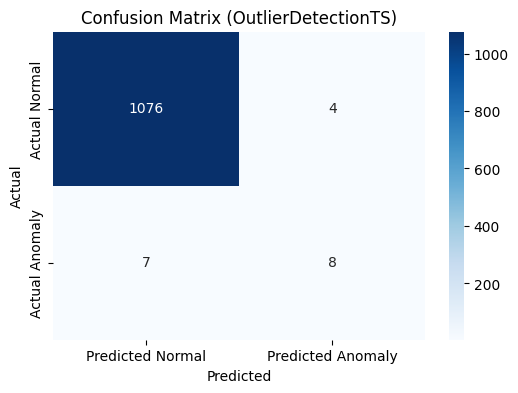


--- Plotting Time Series: Ground Truth vs. Predicted Anomalies ---


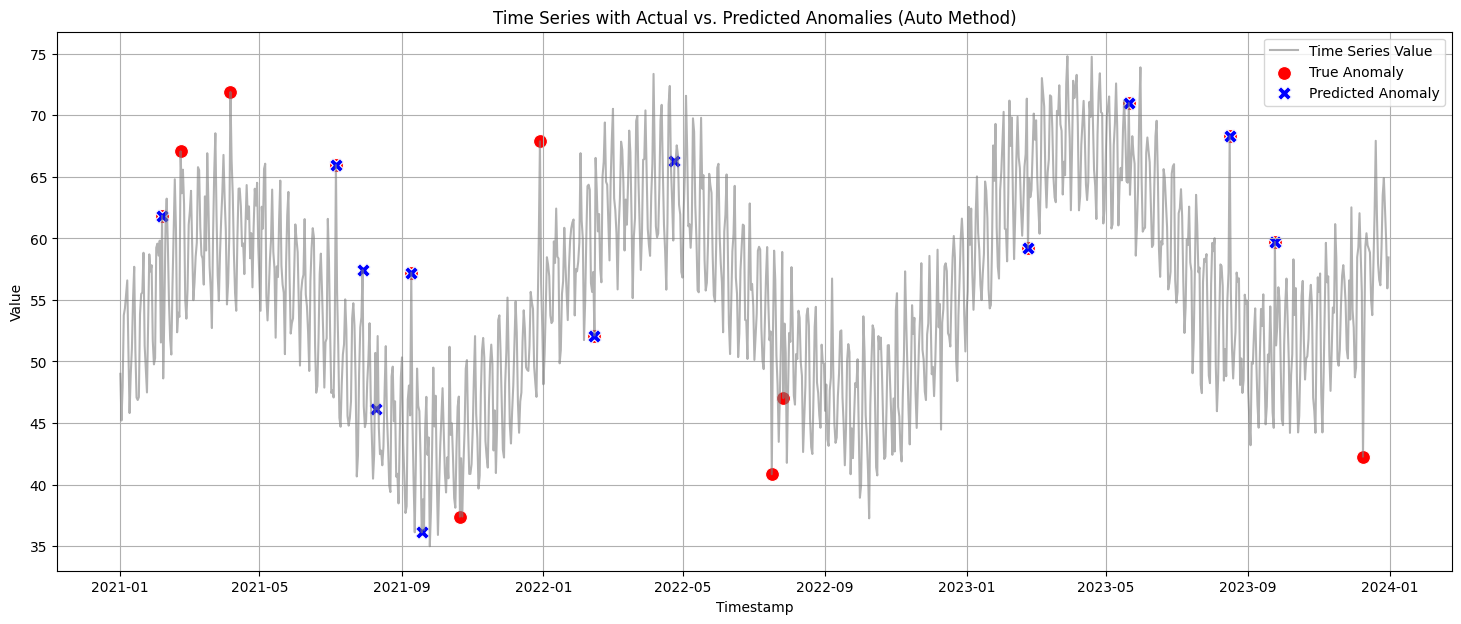

In [14]:
# Ensure we have the results DataFrame
if 'df_results' not in locals() or df_results is None:
     raise SystemExit("Prediction results are not available for evaluation.")
if 'IS_OUTLIER' not in df_results.columns:
     raise SystemExit("Required 'IS_OUTLIER' column not found in prediction results for evaluation.")

# Merge predictions with the original local data (which has the ground truth)
# Use the timestamp column (KEY_COL) for merging
print("\nMerging predictions with ground truth...")
df_merged = pd.merge(df_local[[KEY_COL, TRUTH_COL, ENDOG_COL]], 
                     df_results[[KEY_COL, 'IS_OUTLIER', 'OUTLIER_SCORE', 'RESIDUAL']], # Select relevant columns from results
                     on=KEY_COL, 
                     how='left') # Use left join to keep all original data points

# Rename IS_OUTLIER to predicted_anomaly for consistency with previous notebooks if needed for plotting function
# Note: IS_OUTLIER is already 0 or 1, matching our desired format
df_merged.rename(columns={'IS_OUTLIER': 'predicted_anomaly'}, inplace=True)

print("\nMerged DataFrame Head (with truth and prediction):")
print(df_merged[[KEY_COL, TRUTH_COL, ENDOG_COL, 'predicted_anomaly', 'OUTLIER_SCORE']].head())

# --- Performance Metrics ---
print("\n--- Classification Report ---")
# Compare ground truth (is_anomaly) with the prediction (predicted_anomaly)
print(classification_report(df_merged[TRUTH_COL], df_merged['predicted_anomaly'], target_names=['Normal (0)', 'Anomaly (1)']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(df_merged[TRUTH_COL], df_merged['predicted_anomaly'])
print(cm)
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Anomaly'], yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (OutlierDetectionTS)')
plt.show()

# --- Combined Time Series Plot: Ground Truth vs. Prediction ---
print("\n--- Plotting Time Series: Ground Truth vs. Predicted Anomalies ---")
plt.figure(figsize=(18, 7))
sns.lineplot(data=df_merged, x=KEY_COL, y=ENDOG_COL, label='Time Series Value', color='grey', alpha=0.6)
# Plot true anomalies
true_anomalies = df_merged[df_merged[TRUTH_COL] == 1]
sns.scatterplot(data=true_anomalies, x=KEY_COL, y=ENDOG_COL, color='red', s=100, label='True Anomaly', marker='o')
# Plot predicted anomalies
predicted_anomalies = df_merged[df_merged['predicted_anomaly'] == 1]
sns.scatterplot(data=predicted_anomalies, x=KEY_COL, y=ENDOG_COL, color='blue', s=100, label='Predicted Anomaly', marker='X')

plt.title('Time Series with Actual vs. Predicted Anomalies (Auto Method)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


## 4. Manual Example - Median Smoothing + IQR Outliers

Now, let's explicitly set the smoothing and outlier detection methods instead of using `auto=True`.

OutlierDetectionTS model instantiated (Median + IQR)

Running fit_predict (Median + IQR)...
fit_predict (Median + IQR) completed successfully.

Prediction Results (Median + IQR - Head):
   timestamp   RAW_DATA  RESIDUAL  OUTLIER_SCORE  IS_OUTLIER
0 2021-01-01  48.996025  1.027004       0.045337           0
1 2021-01-02  45.202812  0.967917      -0.164587           0
2 2021-01-03  47.922063  1.002776       0.000000           0
3 2021-01-04  53.763614  1.031598       0.139407           0
4 2021-01-05  54.339912  0.981328       0.000000           0

--- Classification Report (Median + IQR) ---
              precision    recall  f1-score   support

  Normal (0)       1.00      0.98      0.99      1080
 Anomaly (1)       0.44      1.00      0.61        15

    accuracy                           0.98      1095
   macro avg       0.72      0.99      0.80      1095
weighted avg       0.99      0.98      0.99      1095


--- Confusion Matrix (Median + IQR) ---
[[1061   19]
 [   0   15]]


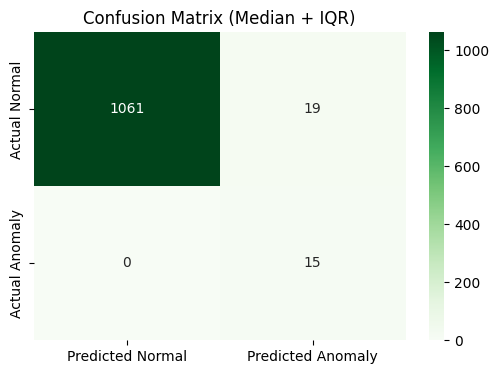


--- Plotting Time Series: Ground Truth vs. Predicted Anomalies (Median + IQR) ---


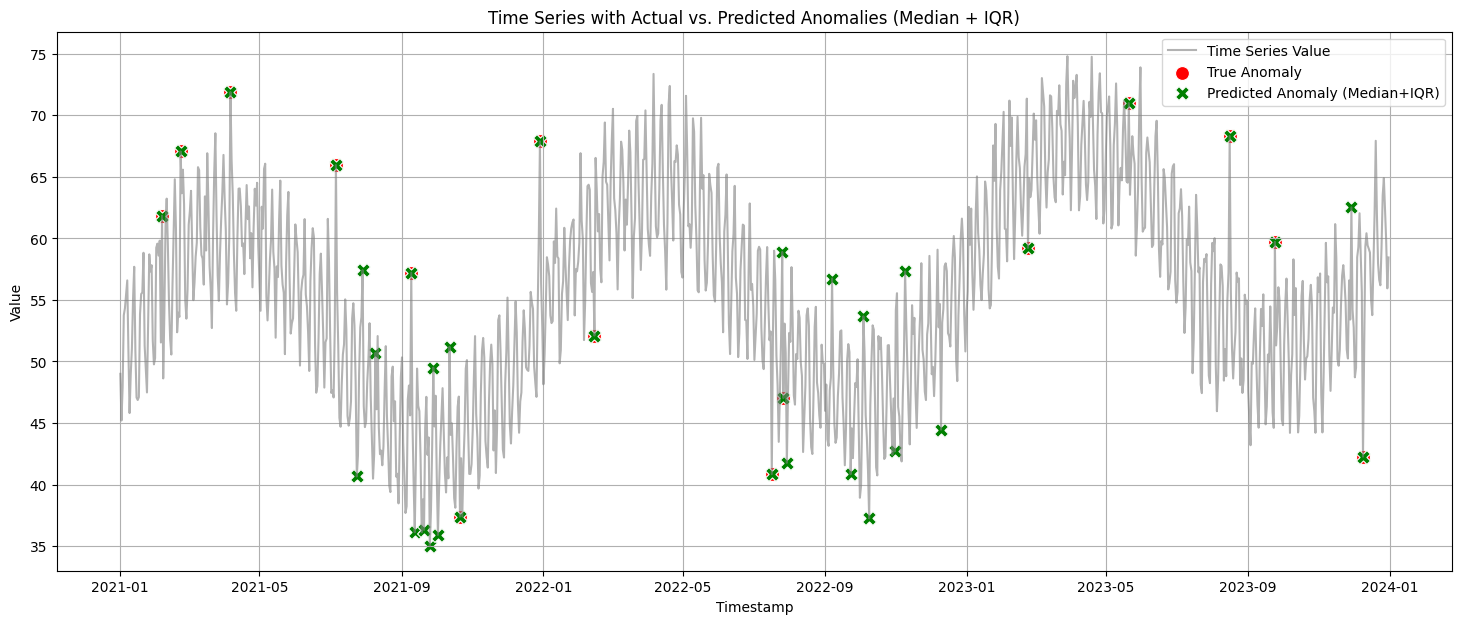

In [15]:
# Instantiate with manual settings: Median filter for smoothing, IQR for outlier detection
tsod_median_iqr = OutlierDetectionTS(
    auto=False,
    smooth_method='median',
    window_size=3, # Default for median
    detect_seasonality=True, # Dataset has seasonal patterns
    outlier_method='iqr',
    threshold=1.5 # Default for IQR
)

print("OutlierDetectionTS model instantiated (Median + IQR)")

# Run fit_predict
print("\nRunning fit_predict (Median + IQR)...")
try:
    results_median_iqr_hdf = tsod_median_iqr.fit_predict(
        data=hdf_input, 
        key=KEY_COL, 
        endog=ENDOG_COL
    )
    print("fit_predict (Median + IQR) completed successfully.")

    # Collect and process results
    if results_median_iqr_hdf:
        df_results_median_iqr = results_median_iqr_hdf.collect()
        df_results_median_iqr['timestamp'] = pd.to_datetime(df_results_median_iqr['timestamp'])
        print("\nPrediction Results (Median + IQR - Head):")
        print(df_results_median_iqr.head())
        
        # Evaluate
        df_merged_median_iqr = pd.merge(df_local[[KEY_COL, TRUTH_COL, ENDOG_COL]], 
                                        df_results_median_iqr[[KEY_COL, 'IS_OUTLIER']], 
                                        on=KEY_COL, 
                                        how='left')
        df_merged_median_iqr.rename(columns={'IS_OUTLIER': 'predicted_anomaly'}, inplace=True)
        
        print("\n--- Classification Report (Median + IQR) ---")
        print(classification_report(df_merged_median_iqr[TRUTH_COL], df_merged_median_iqr['predicted_anomaly'], target_names=['Normal (0)', 'Anomaly (1)']))
        print("\n--- Confusion Matrix (Median + IQR) ---")
        cm_median_iqr = confusion_matrix(df_merged_median_iqr[TRUTH_COL], df_merged_median_iqr['predicted_anomaly'])
        print(cm_median_iqr)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm_median_iqr, annot=True, fmt='d', cmap='Greens', xticklabels=['Predicted Normal', 'Predicted Anomaly'], yticklabels=['Actual Normal', 'Actual Anomaly'])
        plt.title('Confusion Matrix (Median + IQR)')
        plt.show()

        # Plot combined time series
        print("\n--- Plotting Time Series: Ground Truth vs. Predicted Anomalies (Median + IQR) ---")
        plt.figure(figsize=(18, 7))
        sns.lineplot(data=df_merged_median_iqr, x=KEY_COL, y=ENDOG_COL, label='Time Series Value', color='grey', alpha=0.6)
        sns.scatterplot(data=df_merged_median_iqr[df_merged_median_iqr[TRUTH_COL] == 1], x=KEY_COL, y=ENDOG_COL, color='red', s=100, label='True Anomaly', marker='o')
        sns.scatterplot(data=df_merged_median_iqr[df_merged_median_iqr['predicted_anomaly'] == 1], x=KEY_COL, y=ENDOG_COL, color='green', s=100, label='Predicted Anomaly (Median+IQR)', marker='X')
        plt.title('Time Series with Actual vs. Predicted Anomalies (Median + IQR)')
        plt.xlabel('Timestamp')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    else:
        print("fit_predict (Median + IQR) did not return results.")

except Exception as e:
    print(f"Error during fit_predict (Median + IQR): {e}")


## 5. Manual Example - LOESS Smoothing + MAD Outliers

OutlierDetectionTS model instantiated (LOESS + MAD)

Running fit_predict (LOESS + MAD)...
fit_predict (LOESS + MAD) completed successfully.

Prediction Results (LOESS + MAD - Head):
   timestamp   RAW_DATA  RESIDUAL  OUTLIER_SCORE  IS_OUTLIER
0 2021-01-01  48.996025  6.977272       2.023167           0
1 2021-01-02  45.202812 -3.743265      -1.075352           0
2 2021-01-03  47.922063 -2.190185      -0.626471           0
3 2021-01-04  53.763614  2.847386       0.829521           0
4 2021-01-05  54.339912  0.384260       0.117612           0

--- Classification Report (LOESS + MAD) ---
              precision    recall  f1-score   support

  Normal (0)       0.99      1.00      1.00      1080
 Anomaly (1)       1.00      0.47      0.64        15

    accuracy                           0.99      1095
   macro avg       1.00      0.73      0.82      1095
weighted avg       0.99      0.99      0.99      1095


--- Confusion Matrix (LOESS + MAD) ---
[[1080    0]
 [   8    7]]


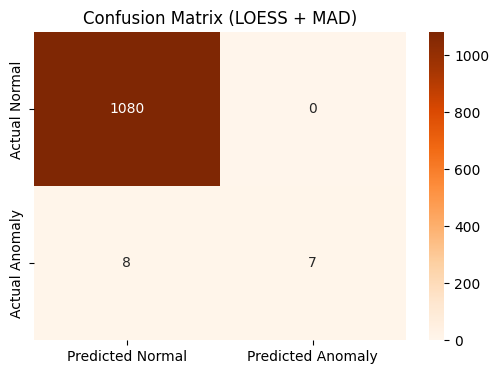


--- Plotting Time Series: Ground Truth vs. Predicted Anomalies (LOESS + MAD) ---


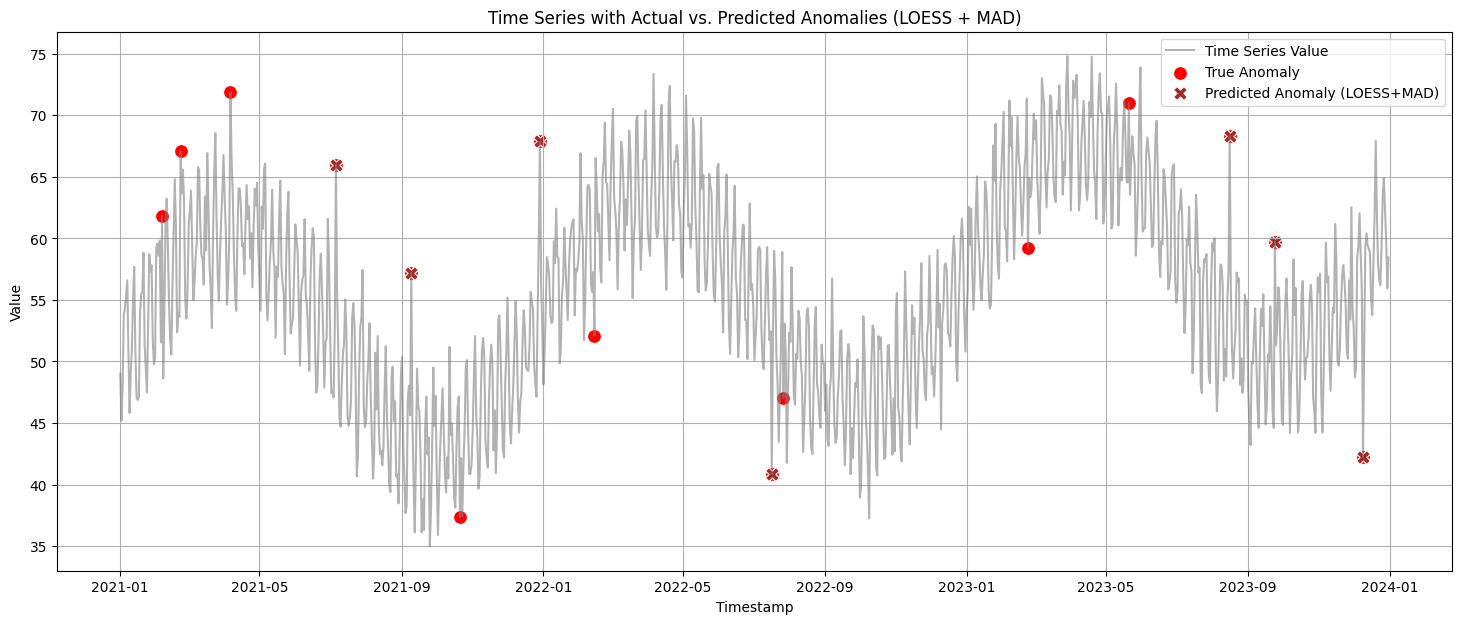

In [16]:
# Instantiate with manual settings: LOESS for smoothing, MAD for outlier detection
tsod_loess_mad = OutlierDetectionTS(
    auto=False,
    smooth_method='loess',
    loess_lag=7, # Default for loess
    outlier_method='mad',
    threshold=3.0, # Default for MAD
)

print("OutlierDetectionTS model instantiated (LOESS + MAD)")

# Run fit_predict
print("\nRunning fit_predict (LOESS + MAD)...")
try:
    results_loess_mad_hdf = tsod_loess_mad.fit_predict(
        data=hdf_input, 
        key=KEY_COL, 
        endog=ENDOG_COL
    )
    print("fit_predict (LOESS + MAD) completed successfully.")

    # Collect and process results
    if results_loess_mad_hdf:
        df_results_loess_mad = results_loess_mad_hdf.collect()
        df_results_loess_mad['timestamp'] = pd.to_datetime(df_results_loess_mad['timestamp'])
        print("\nPrediction Results (LOESS + MAD - Head):")
        print(df_results_loess_mad.head())
        
        # Evaluate
        df_merged_loess_mad = pd.merge(df_local[[KEY_COL, TRUTH_COL, ENDOG_COL]], 
                                       df_results_loess_mad[[KEY_COL, 'IS_OUTLIER']], 
                                       on=KEY_COL, 
                                       how='left')
        df_merged_loess_mad.rename(columns={'IS_OUTLIER': 'predicted_anomaly'}, inplace=True)
        
        print("\n--- Classification Report (LOESS + MAD) ---")
        print(classification_report(df_merged_loess_mad[TRUTH_COL], df_merged_loess_mad['predicted_anomaly'], target_names=['Normal (0)', 'Anomaly (1)']))
        print("\n--- Confusion Matrix (LOESS + MAD) ---")
        cm_loess_mad = confusion_matrix(df_merged_loess_mad[TRUTH_COL], df_merged_loess_mad['predicted_anomaly'])
        print(cm_loess_mad)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm_loess_mad, annot=True, fmt='d', cmap='Oranges', xticklabels=['Predicted Normal', 'Predicted Anomaly'], yticklabels=['Actual Normal', 'Actual Anomaly'])
        plt.title('Confusion Matrix (LOESS + MAD)')
        plt.show()

        # Plot combined time series
        print("\n--- Plotting Time Series: Ground Truth vs. Predicted Anomalies (LOESS + MAD) ---")
        plt.figure(figsize=(18, 7))
        sns.lineplot(data=df_merged_loess_mad, x=KEY_COL, y=ENDOG_COL, label='Time Series Value', color='grey', alpha=0.6)
        sns.scatterplot(data=df_merged_loess_mad[df_merged_loess_mad[TRUTH_COL] == 1], x=KEY_COL, y=ENDOG_COL, color='red', s=100, label='True Anomaly', marker='o')
        sns.scatterplot(data=df_merged_loess_mad[df_merged_loess_mad['predicted_anomaly'] == 1], x=KEY_COL, y=ENDOG_COL, color='brown', s=100, label='Predicted Anomaly (LOESS+MAD)', marker='X')
        plt.title('Time Series with Actual vs. Predicted Anomalies (LOESS + MAD)')
        plt.xlabel('Timestamp')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    else:
        print("fit_predict (LOESS + MAD) did not return results.")

except Exception as e:
    print(f"Error during fit_predict (LOESS + MAD): {e}")


## 6. Manual Example - No Smoothing + Isolation Forest Outliers

OutlierDetectionTS model instantiated (No Smooth + Isolation Forest)

Running fit_predict (No Smooth + Isolation Forest)...
fit_predict (No Smooth + Isolation Forest) completed successfully.

Prediction Results (No Smooth + Isolation Forest - Head):
   timestamp   RAW_DATA   RESIDUAL  OUTLIER_SCORE  IS_OUTLIER
0 2021-01-01  48.996025  48.996025       0.478070           0
1 2021-01-02  45.202812  45.202812       0.532193           0
2 2021-01-03  47.922063  47.922063       0.491417           0
3 2021-01-04  53.763614  53.763614       0.469506           0
4 2021-01-05  54.339912  54.339912       0.460070           0

--- Classification Report (No Smooth + Isolation Forest) ---
              precision    recall  f1-score   support

  Normal (0)       0.99      0.99      0.99      1080
 Anomaly (1)       0.07      0.07      0.07        15

    accuracy                           0.97      1095
   macro avg       0.53      0.53      0.53      1095
weighted avg       0.97      0.97      0.97 

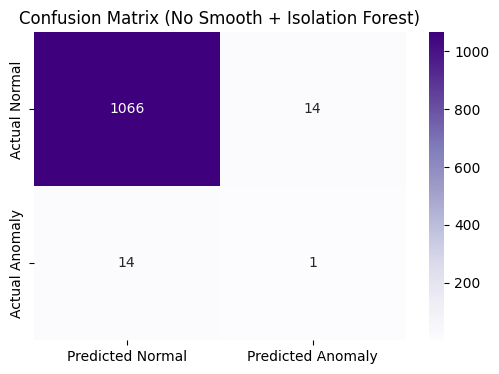


--- Plotting Time Series: Ground Truth vs. Predicted Anomalies (No Smooth + Isolation Forest) ---


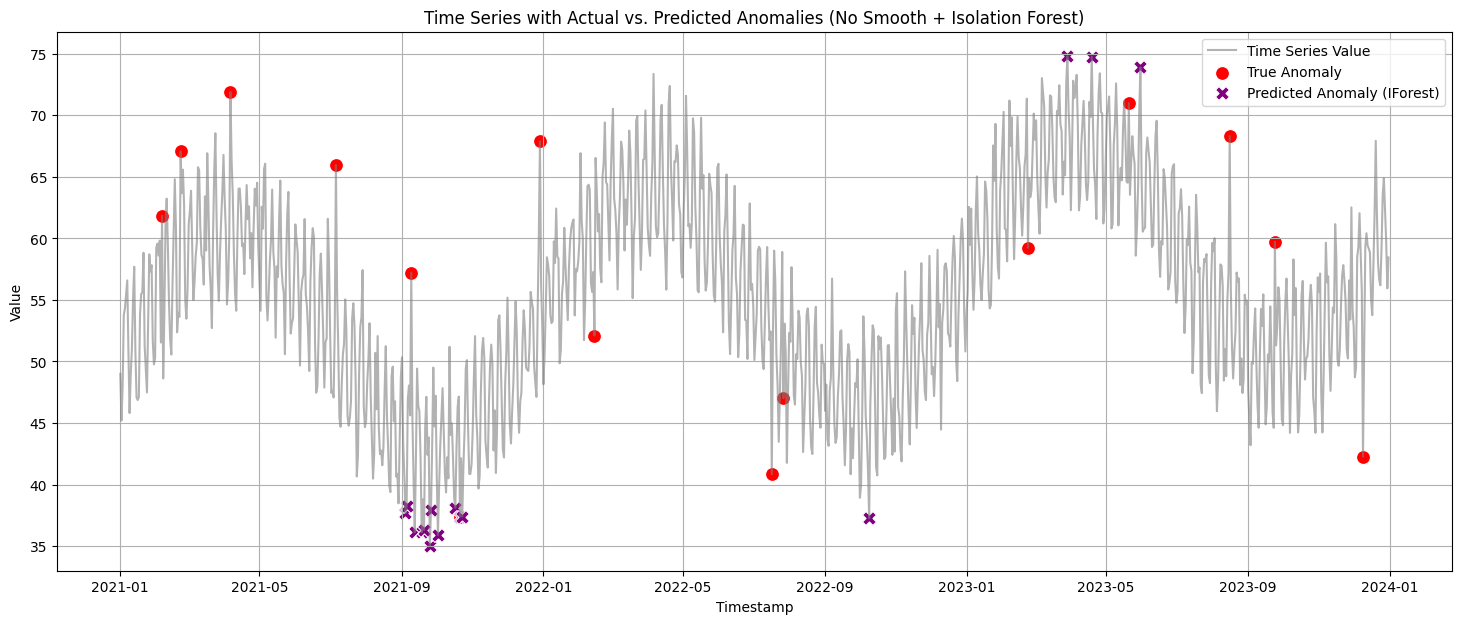

In [17]:
# Instantiate with manual settings: No smoothing, Isolation Forest for outlier detection
tsod_iforest = OutlierDetectionTS(
    auto=False,
    smooth_method='no', # No smoothing, detect on raw data (or residuals if applicable)
    outlier_method='isolationforest',
    contamination=float(actual_contamination), # Use calculated contamination
    # threshold=0.7, # Default for isolationforest, but overridden by contamination
    random_state=42 # For reproducibility of Isolation Forest
)

print("OutlierDetectionTS model instantiated (No Smooth + Isolation Forest)")

# Run fit_predict
print("\nRunning fit_predict (No Smooth + Isolation Forest)...")
try:
    results_iforest_hdf = tsod_iforest.fit_predict(
        data=hdf_input, 
        key=KEY_COL, 
        endog=ENDOG_COL
    )
    print("fit_predict (No Smooth + Isolation Forest) completed successfully.")

    # Collect and process results
    if results_iforest_hdf:
        df_results_iforest = results_iforest_hdf.collect()
        df_results_iforest['timestamp'] = pd.to_datetime(df_results_iforest['timestamp'])
        print("\nPrediction Results (No Smooth + Isolation Forest - Head):")
        print(df_results_iforest.head())
        
        # Evaluate
        df_merged_iforest = pd.merge(df_local[[KEY_COL, TRUTH_COL, ENDOG_COL]], 
                                     df_results_iforest[[KEY_COL, 'IS_OUTLIER']], 
                                     on=KEY_COL, 
                                     how='left')
        df_merged_iforest.rename(columns={'IS_OUTLIER': 'predicted_anomaly'}, inplace=True)
        
        print("\n--- Classification Report (No Smooth + Isolation Forest) ---")
        print(classification_report(df_merged_iforest[TRUTH_COL], df_merged_iforest['predicted_anomaly'], target_names=['Normal (0)', 'Anomaly (1)']))
        print("\n--- Confusion Matrix (No Smooth + Isolation Forest) ---")
        cm_iforest = confusion_matrix(df_merged_iforest[TRUTH_COL], df_merged_iforest['predicted_anomaly'])
        print(cm_iforest)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm_iforest, annot=True, fmt='d', cmap='Purples', xticklabels=['Predicted Normal', 'Predicted Anomaly'], yticklabels=['Actual Normal', 'Actual Anomaly'])
        plt.title('Confusion Matrix (No Smooth + Isolation Forest)')
        plt.show()

        # Plot combined time series
        print("\n--- Plotting Time Series: Ground Truth vs. Predicted Anomalies (No Smooth + Isolation Forest) ---")
        plt.figure(figsize=(18, 7))
        sns.lineplot(data=df_merged_iforest, x=KEY_COL, y=ENDOG_COL, label='Time Series Value', color='grey', alpha=0.6)
        sns.scatterplot(data=df_merged_iforest[df_merged_iforest[TRUTH_COL] == 1], x=KEY_COL, y=ENDOG_COL, color='red', s=100, label='True Anomaly', marker='o')
        sns.scatterplot(data=df_merged_iforest[df_merged_iforest['predicted_anomaly'] == 1], x=KEY_COL, y=ENDOG_COL, color='purple', s=100, label='Predicted Anomaly (IForest)', marker='X')
        plt.title('Time Series with Actual vs. Predicted Anomalies (No Smooth + Isolation Forest)')
        plt.xlabel('Timestamp')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    else:
        print("fit_predict (No Smooth + Isolation Forest) did not return results.")

except Exception as e:
    print(f"Error during fit_predict (No Smooth + Isolation Forest): {e}")


## 7. Cleanup

Finally, let's remove the table we created in HANA.

In [18]:
print("\n--- Cleaning up HANA tables ---")
tables_to_drop = [TABLE_NAME]

for table in tables_to_drop:
    try:
        cc.drop_table(table)
        print(f"Dropped table: {table}")
    except Exception as e:
        print(f"Could not drop table {table} (may not exist or permissions issue): {e}")

# Close the connection
try:
    cc.close()
    print("\nHANA connection closed.")
except Exception as e:
    print(f"Error closing connection: {e}")


--- Cleaning up HANA tables ---
Dropped table: SYNTHETIC_TS_ANOMALY_DATA_ODTS

HANA connection closed.
